In [47]:
import os
from langchain.chat_models import ChatOpenAI
from langchain_community.document_loaders import DirectoryLoader
from langchain.indexes import VectorstoreIndexCreator
from langchain.vectorstores import DocArrayInMemorySearch
from langchain.chains import RetrievalQA
from langchain.prompts import ChatPromptTemplate
from dotenv import load_dotenv
from collections import Counter
from unidecode import unidecode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string

## Useful materials
https://wandb.ai/ayush-thakur/llm-eval-sweep/reports/How-to-Evaluate-Compare-and-Optimize-LLM-Systems--Vmlldzo0NzgyMTQz \
https://intellica-ai.medium.com/comparison-of-different-word-embeddings-on-text-similarity-a-use-case-in-nlp-e83e08469c1c \
https://christiangrech.medium.com/evaluating-rag-performance-a-comprehensive-guide-b1d8f903b7ad

# Setup

## Setup environment

In [48]:
load_dotenv()

True

In [49]:
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

## Setup NLTK

In [50]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vladimirskvortsov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vladimirskvortsov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vladimirskvortsov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Dataset

## Load dataset

In [51]:
loader = DirectoryLoader('dataset', '*.tex')
docs = loader.load()
len(docs)

22

## Stores

In [52]:
index = VectorstoreIndexCreator(
  vectorstore_cls=DocArrayInMemorySearch,
).from_loaders([loader])

# LLMs

## gpt-3.5-turbo + vector store

In [53]:
openai_llm = ChatOpenAI(temperature=0, model='gpt-3.5-turbo')
openai_qa_llm = RetrievalQA.from_chain_type(
  llm=openai_llm,
  chain_type="stuff",
  retriever=index.vectorstore.as_retriever(),
  verbose=True,
  chain_type_kwargs = {
    'document_separator': '<<<<>>>>>',
  },
)

In [54]:
openai_qa_llm.run('Как задается распределение Пуассона?')



> Entering new RetrievalQA chain...

> Finished chain.


'Распределение Пуассона задается через вероятности появления различного количества событий в фиксированном интервале времени или пространства. В таблице распределения Пуассона указываются вероятности $P(X=k)$ для $k=0, 1, 2, \\ldots$, где $X$ - случайная величина, представляющая количество событий. \n\nДля распределения Пуассона вероятность $P(X=k)$ вычисляется по формуле $P(X=k) = \\frac{\\lambda^k}{k!} e^{-\\lambda}$, где $\\lambda$ - параметр распределения, который представляет собой среднее количество событий за фиксированный интервал времени или пространства. \n\nТаким образом, распределение Пуассона характеризуется экспоненциальным убыванием вероятностей с увеличением количества событий и параметром $\\lambda$, который также является средним значением и дисперсией этого распределения.'

## LLAMA 2 + vector store

In [55]:
from langchain_community.llms import Ollama

llama_llm = Ollama(temperature=0, model='llama2')
llama_qa_llm = RetrievalQA.from_chain_type(
  llm=llama_llm,
  chain_type="stuff",
  retriever=index.vectorstore.as_retriever(),
  verbose=True,
  chain_type_kwargs = {
    'document_separator': '<<<<>>>>>',
  },
)

In [56]:
llama_qa_llm.run('Как задается распределение Пуассона?')



> Entering new RetrievalQA chain...

> Finished chain.


'The distribution of the Poisson process is defined as follows:\n\nLet $N$ be a positive integer, and let $X_1, X_2, \\ldots$ be a sequence of independent and identically distributed random variables with probability mass function $p_N(k) = e^{-\\lambda} \\frac{\\lambda^k}{k!}$. Then the distribution of the Poisson process with parameter $\\lambda$ is defined as the probability measure $\\mu_X$ given by:\n\n$$\\mu_X(A) = \\sum_{k=0}^{\\infty} p_N(k) \\delta_{X_N}(A)$$\n\nwhere $A \\in \\mathcal{B}(\\mathbb{R})$ is a Borel set, and $\\delta_{X_N}$ is the Dirac delta function at $X_N$.\n\nIn other words, the distribution of the Poisson process is the sum of the probability masses of the individual random variables $X_i$, normalized to integrate to 1. The parameter $\\lambda$ is not explicitly mentioned in the definition of the distribution, but it is assumed to be a fixed constant.'

# Metrics

## Preprocess

In [57]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def preprocess(corpus):
  corpus = corpus.lower()
  stopset = nltk.corpus.stopwords.words('english') + nltk.corpus.stopwords.words('russian') + list(string.punctuation)
  tokens = nltk.word_tokenize(corpus)
  tokens = [t for t in tokens if t not in stopset]
  tokens = [lemmatizer.lemmatize(t) for t in tokens]
  corpus = ' '.join(tokens)
  corpus = unidecode(corpus)
  return corpus

preprocess("Дисперсией случайной величины $X$ называется число $\\mathbb{D}X = \\mathbb{E}(X - \\mathbb{E}X) ^ 2$.")

'dispersiei sluchainoi velichiny x nazyvaetsia chislo \\mathbb x \\mathbb e x \\mathbb e x 2'

## Questions and True Answers

## Experiment 1: Unigrams Overlap (Precision, Recall and F1-Score)

In [58]:
questions = [
  {
    'question': 'Дисперсия случайной величины',
    'answer': 'Дисперсией случайной величины $X$ называется число $\\mathbb{D}X = \\mathbb{E}(X - \\mathbb{E}X) ^ 2$.',
  },
  {
    'question': 'Докажи неравенство Чебышёва',
    'answer': 'Пусть $A = {\\omega:X(\\omega) \\geqslant t}$. Тогда $X \\geqslant t \\cdot I_A$, и значит $\\mathbb{E}X \\geqslant tP(A)$.',
  },
  {
    'question': 'Дай определение формулы Байеса',
    'answer': 'Пусть $P(B) > 0$. Условной вероятностью события $A$ при условии $B$ называется число $P(A|B) = \\dfrac{P(A \\cap B)}{P(B)}$. Если фиксировать событие $B$, то функция $P(\\cdot|B)$ является новой вероятностной мерой, т.е. удовлетворяет свойствам (i) и (ii) (или (ii)\', если таковой была исходная вероятностная мера $P$). Равенство из определения часто переписывают в виде $P(A \\cap B) = P(A|B)P(B)$ и называют правилом произведения.',
  },
  {
    'question': 'Что такое ковариация?',
    'answer': 'Ковариацией пары случайных величин $X, Y$ называется число $\\mathrm{cov}(X, Y) = \\mathbb{E} \\left( (X - \\mathbb{E}X)(Y - \\mathbb{E}Y) \\right)$.',
  },
  {
    'question': 'Определение характеристической функции',
    'answer': 'Пусть $X$ это случайная величина. Тогда характеристическая функция случайной величины $X$ это\n\\begin{equation*}\n\\phi_X(t) := \\E[e^{itX}] = \\E[\\cos (t \\cdot X)] + i \\cdot \\E[\\sin (t \\cdot X)].\n\\end{equation*}',
  },
  {
    'question': 'Формулировка теоремы об однозначности задания совместного распределения функцией совместного распределения и о существовании распределения с заданой функцией совместного распределения',
    'answer': 'Совместное распределение пары случайных величин $\\mu_{X, Y}$ однозначно задается функцией совместного распределения $F_{X, Y}$.\nКроме того, для всякой функции $F$, удовлетворяющей свойствам $(1), (2), (3), (4),$ существует вероятностное пространство $(\\Omega, \\mathcal{A}, P)$ и пара случайных величин $X, Y$ с функцией совместного распределения $F$.',
  },
]

In [59]:
def unigrams_overlap_recall_metric(expected_answers, predicted_answers):
  results = []

  for expected_answer, predicted_answer in zip(expected_answers, predicted_answers):
    expected_answer = preprocess(expected_answer)
    predicted_answer = preprocess(predicted_answer)

    expected_tokens = nltk.word_tokenize(expected_answer)
    predicted_tokens = nltk.word_tokenize(predicted_answer)

    expected_count = Counter(expected_tokens)
    predicted_count = Counter(predicted_tokens)
    overlap = sum(min(predicted_count[w], expected_count[w]) for w in predicted_count)

    recall = overlap / len(expected_tokens)

    results.append(recall)

  return np.mean(results)

In [60]:
def unigrams_overlap_precision_metric(expected_answers, predicted_answers):
  results = []

  for expected_answer, predicted_answer in zip(expected_answers, predicted_answers):
    expected_answer = preprocess(expected_answer)
    predicted_answer = preprocess(predicted_answer)

    expected_tokens = nltk.word_tokenize(expected_answer)
    predicted_tokens = nltk.word_tokenize(predicted_answer)

    expected_count = Counter(expected_tokens)
    predicted_count = Counter(predicted_tokens)
    overlap = sum(min(predicted_count[w], expected_count[w]) for w in predicted_count)

    precision = overlap / len(predicted_tokens)

    results.append(precision)

  return np.mean(results)

In [61]:
def unigrams_overlap_f1_metric(expected_answers, predicted_answers):
  results = []

  for expected_answer, predicted_answer in zip(expected_answers, predicted_answers):
    expected_answer = preprocess(expected_answer)
    predicted_answer = preprocess(predicted_answer)

    expected_tokens = nltk.word_tokenize(expected_answer)
    predicted_tokens = nltk.word_tokenize(predicted_answer)

    expected_count = Counter(expected_tokens)
    predicted_count = Counter(predicted_tokens)
    overlap = sum(min(predicted_count[w], expected_count[w]) for w in predicted_count)

    recall = overlap / len(expected_tokens)
    precision = overlap / len(predicted_tokens)
    f1 = 2 * (recall * precision) / (recall + precision)

    results.append(f1)

  return np.mean(results)

## Experiment 2: Inverse Embeddings Euclidean Distance

In [62]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [63]:
len(embeddings.embed_query('asdasd'))

3072

In [64]:
def embeddings_euclidean_dist_metric(expected_answers, predicted_answers):
  results = []

  for expected_answer, predicted_answer in zip(expected_answers, predicted_answers):
    expected_answer = preprocess(expected_answer)
    predicted_answer = preprocess(predicted_answer)

    expected_embedding = np.array(embeddings.embed_query(expected_answer))
    predicted_embedding = np.array(embeddings.embed_query(predicted_answer))

    abs_diff = np.linalg.norm(expected_embedding - predicted_embedding)
    result = 1 / abs_diff

    results.append(result)

  return np.mean(results)

## Experiment 3: Embeddings Cosine Similarity

In [65]:
from sklearn.metrics.pairwise import cosine_similarity

def embeddings_cosine_sim_metric(expected_answers, predicted_answers):
  results = []

  for expected_answer, predicted_answer in zip(expected_answers, predicted_answers):
    expected_answer = preprocess(expected_answer)
    predicted_answer = preprocess(predicted_answer)

    expected_embedding = np.array(embeddings.embed_query(expected_answer))
    predicted_embedding = np.array(embeddings.embed_query(predicted_answer))

    sim = cosine_similarity(
      expected_embedding.reshape(1, -1),
      predicted_embedding.reshape(1, -1),
    )[0][0]

    results.append(sim)

  return np.mean(results)

## Experiment 4: LLM Mean Grade

In [66]:
template = """
  Your job is to rate the quality of our generated answer {generated_answer}
  given a query {query}.
  Your score has to be a float between 0 and 10.
  You must return your response in a line with only the score.
  Do not return answers in any other format.
"""
prompt_template = ChatPromptTemplate.from_template(template)

def llm_mean_grade(questions, predicted_answers):
  results = []

  for question, predicted_answer in zip(questions, predicted_answers):
    messages = prompt_template.format_messages(
      generated_answer=predicted_answer,
      query=question,
    )
    response = openai_llm(messages)
    grade = float(response.content) / 10

    results.append(grade)

  return np.mean(results)

# Testing

In [67]:
qa_llms = [
  {'name': 'Open AI GPT 3.5 Turbo', 'qa_llm': openai_qa_llm},
  {'name': 'LLAMA 2', 'qa_llm': llama_qa_llm},
]
metrics = [
  {
    'name': 'Unigrams Overlap Recall',
    'f': lambda questions, expected_answers, predicted_answers: unigrams_overlap_recall_metric(expected_answers, predicted_answers),
  },
  {
    'name': 'Unigrams Overlap Precision',
    'f': lambda questions, expected_answers, predicted_answers: unigrams_overlap_precision_metric(expected_answers, predicted_answers),
  },
  {
    'name': 'Unigrams Overlap F1-Score',
    'f': lambda questions, expected_answers, predicted_answers: unigrams_overlap_f1_metric(expected_answers, predicted_answers),
  },
  {
    'name': 'Embedding Euclidean Distance',
    'f': lambda questions, expected_answers, predicted_answers: embeddings_euclidean_dist_metric(expected_answers, predicted_answers),
  },
  {
    'name': 'Embeddings Cosine Similarity',
    'f': lambda questions, expected_answers, predicted_answers: embeddings_cosine_sim_metric(expected_answers, predicted_answers),
  },
  {
    'name': 'LLM mean grade',
    'f': lambda questions, expected_answers, predicted_answers: llm_mean_grade(questions, predicted_answers),
  },
]

In [68]:
results = pd.DataFrame(
  {item['name']: np.zeros(len(metrics)) for item in qa_llms},
  index=list(map(lambda e: e['name'], metrics)),
)
results

,Open AI GPT 3.5 Turbo,LLAMA 2
Unigrams Overlap Recall,0.0,0.0
Unigrams Overlap Precision,0.0,0.0
Unigrams Overlap F1-Score,0.0,0.0
Embedding Euclidean Distance,0.0,0.0
Embeddings Cosine Similarity,0.0,0.0
LLM mean grade,0.0,0.0


In [70]:
data = {}

for qa_llm in qa_llms:
  raw_questions = []
  expected_answers = []
  predicted_answers = []

  for question in questions:
    raw_questions.append(question['question'])
    expected_answers.append(question['answer'])
    predicted_answers.append(qa_llm['qa_llm'].run(question['question']))

  data[qa_llm['name']] = {
    'questions': raw_questions,
    'expected_answers': expected_answers,
    'predicted_answers': predicted_answers,
  }

data



> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


{'Open AI GPT 3.5 Turbo': {'questions': ['Дисперсия случайной величины',
   'Докажи неравенство Чебышёва',
   'Дай определение формулы Байеса',
   'Что такое ковариация?',
   'Определение характеристической функции',
   'Формулировка теоремы об однозначности задания совместного распределения функцией совместного распределения и о существовании распределения с заданой функцией совместного распределения'],
  'expected_answers': ['Дисперсией случайной величины $X$ называется число $\\mathbb{D}X = \\mathbb{E}(X - \\mathbb{E}X) ^ 2$.',
   'Пусть $A = {\\omega:X(\\omega) \\geqslant t}$. Тогда $X \\geqslant t \\cdot I_A$, и значит $\\mathbb{E}X \\geqslant tP(A)$.',
   "Пусть $P(B) > 0$. Условной вероятностью события $A$ при условии $B$ называется число $P(A|B) = \\dfrac{P(A \\cap B)}{P(B)}$. Если фиксировать событие $B$, то функция $P(\\cdot|B)$ является новой вероятностной мерой, т.е. удовлетворяет свойствам (i) и (ii) (или (ii)', если таковой была исходная вероятностная мера $P$). Равенство

In [72]:
for qa_name in data:
  raw_questions = data[qa_name]['questions']
  expected_answers = data[qa_name]['expected_answers']
  predicted_answers = data[qa_name]['predicted_answers']

  for metric in metrics:
    print(qa_name, metric['name'])
    result = metric['f'](raw_questions, expected_answers, predicted_answers)
    results.loc[metric['name'], qa_llm['name']] = result

results

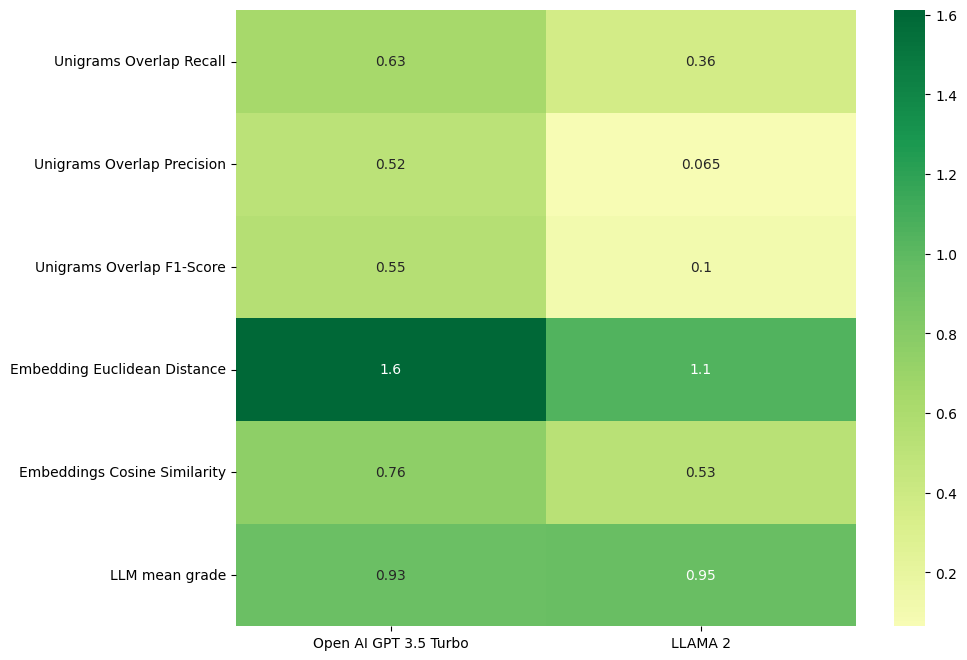

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(results, annot=True, cmap='RdYlGn', center=0)
plt.show()